In [ ]:
# Pandas
import pandas as pd

# Configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Sklearn e Skforecast
from sklearn.ensemble import RandomForestRegressor

!pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.1 MB/s eta 0:00:00


In [ ]:
# Carrega dados

url = 'https://raw.githubusercontent.com/alantrs/series-temporais/main/daily-minimum-temperatures-in-melbou.csv'
data = pd.read_csv(url, sep=',')
data.head(5)

,Date,Daily minimum temperatures in Melbourne
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [ ]:
# Tratamento de dados

# Renomeia as colunas
data = data.rename(columns={'Daily minimum temperatures in Melbourne': 'temp min', 'Date': 'date'})

# Converte a coluna 'temp min' para numérico
data['temp min'] = pd.to_numeric(data['temp min'], errors='coerce')

# Para remover as linhas com valores ausentes
data = data.dropna()

# Converte data de string para datetime e transforma em índice
data['date'] = pd.to_datetime(data['date'])

# Seto o índice
data = data.set_index('date')

# Defino a frequência
data = data.asfreq('MS', fill_value=0.0)

# Ordena pela data
data = data.sort_index()

data.head(5)

,temp min
date,
1981-01-01,20.7
1981-02-01,15.3
1981-03-01,17.8
1981-04-01,16.7
1981-05-01,8.6


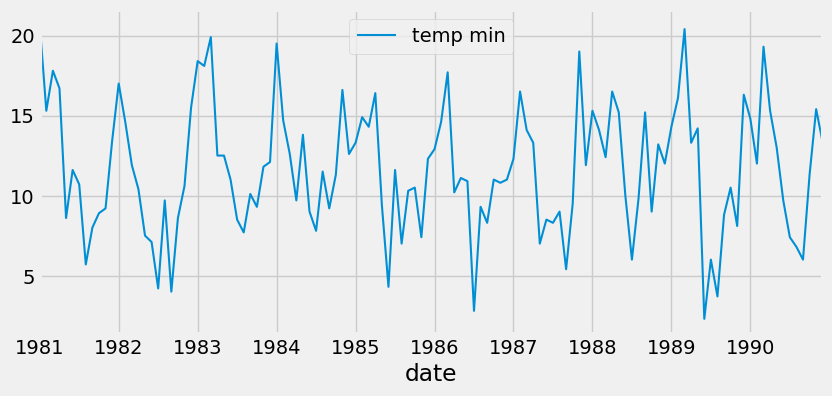

In [ ]:
# Grafico

# Plota os dados
# Cria uma figura com tamanho especificado
fig, ax = plt.subplots(figsize=(9, 4))

data['temp min'].plot(ax=ax, label='temp min')
ax.legend()

# Exibe o gráfico
plt.show()


In [ ]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [ ]:
# Código para verificar se não existem "buracos" nos dados
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

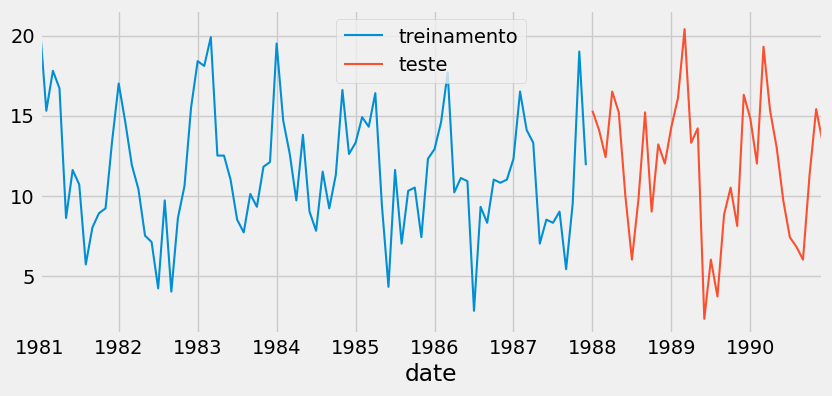

In [ ]:
# Divide dados em treinamento e teste
# Para séries temporais, sempre utilizamos os dados mais recentes para teste
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plotando os dados
fig, ax=plt.subplots(figsize=(9, 4))
data_train['temp min'].plot(ax=ax, label='treinamento')
data_test['temp min'].plot(ax=ax, label='teste')
ax.legend();

# Exibe o gráfico
plt.show()

In [ ]:

# Tunning
# Usara combinacoes aleatorias dos parametros
# ==============================================================================
from skforecast.model_selection import random_search_forecaster
import numpy as np

forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # O valor será substituído durante o tunning
             )

# Valores de lag a testar
lags_grid = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12]

# Regressor hyperparameters
param_distributions = {'n_estimators': np.arange(start=10, stop=100, step=1, dtype=int),
                       'max_depth': np.arange(start=5, stop=30, step=1, dtype=int)}

results = random_search_forecaster(
              forecaster           = forecaster,
              y                    = data['temp min'],
              steps                = steps,
              lags_grid            = lags_grid,
              param_distributions  = param_distributions,
              n_iter               = 100,
              metric               = 'mean_squared_error',
              refit                = True,
              initial_train_size   = len(data['temp min']) - steps,
              fixed_train_size     = False,
              return_best          = True,
              random_state         = 123,
              verbose              = False
          )

results

Number of models compared: 1000.


lags grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/100 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'n_estimators': 54, 'max_depth': 7}
  Backtesting metric: 7.924442608388022



,lags,lags_label,params,mean_squared_error,n_estimators,max_depth
554,"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 54, 'max_depth': 7}",7.924443,54,7
515,"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 38, 'max_depth': 9}",8.011225,38,9
568,"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 40, 'max_depth': 6}",8.194589,40,6
500,"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 44, 'max_depth': 11}",8.200529,44,11
811,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'n_estimators': 64, 'max_depth': 18}",8.350968,64,18
...,...,...,...,...,...,...
234,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'n_estimators': 11, 'max_depth': 14}",32.850751,11,14
134,"[1, 2, 3]","[1, 2, 3]","{'n_estimators': 11, 'max_depth': 14}",33.372445,11,14
192,"[1, 2, 3]","[1, 2, 3]","{'n_estimators': 34, 'max_depth': 29}",34.828327,34,29
236,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'n_estimators': 10, 'max_depth': 25}",38.887897,10,25


In [ ]:
# Configura e treina um RandomForestRegressor para série temporal
# Os parâmetros foram retirados do melhor modelo encontrado no material de origem
# Para conseguir os melhores parâmetros se faz necessário realizer hyperparameter tunning (verifique artigo original)
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=7, n_estimators=54, random_state=123),
                lags      = 7
             )

forecaster.fit(y=data_train['temp min'])

# Faz a previsão no conjunto de teste
predictions = forecaster.predict(steps=steps)
predictions.head(5)

1988-01-01    14.287569
1988-02-01    14.689544
1988-03-01    13.833022
1988-04-01    13.054929
1988-05-01    10.725379
Freq: MS, Name: pred, dtype: float64

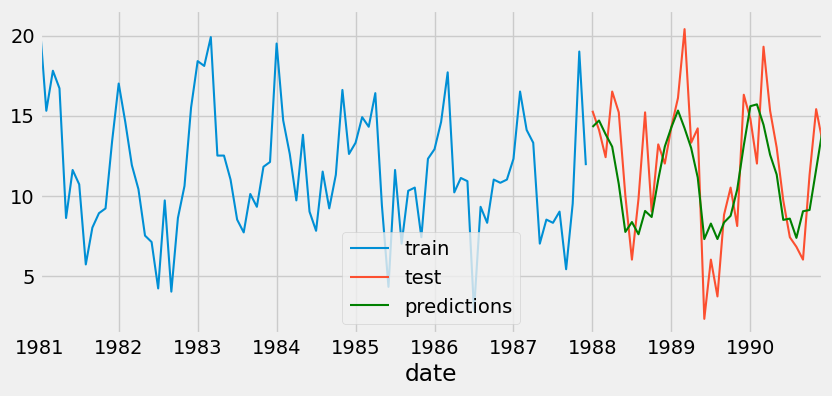

In [ ]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(9, 4))
data_train['temp min'].plot(ax=ax, label='train')
data_test['temp min'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend();

# Exibe o gráfico
plt.show()